# DASMatrix 完整教程

**分布式声学传感（DAS）数据处理与分析框架**

本教程将全面介绍 DASMatrix 的核心功能，包括：

1. 数据创建与读取
2. 链式信号处理
3. 频域分析
4. 事件检测
5. Nature/Science 级别可视化

---

## 1. 环境准备

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt

# 导入 DASMatrix 模块
from DASMatrix.api import df
from DASMatrix.api.dasframe import DASFrame
from DASMatrix.visualization import (
    apply_nature_style,
    create_figure,
    nature_style,
)
from DASMatrix.config import VisualizationConfig, FigureSize

# 应用 Nature 风格（全局）
apply_nature_style()

print("DASMatrix 加载成功！")

DASMatrix 加载成功！


## 2. 创建合成 DAS 数据

在没有真实 DAS 数据的情况下，我们创建一些模拟数据用于演示。

In [2]:
def create_synthetic_das_data(
    duration=2.0,      # 持续时间（秒）
    fs=1000,           # 采样率（Hz）
    n_channels=64,     # 通道数
    signal_freq=50,    # 主信号频率（Hz）
    noise_level=0.2    # 噪声水平
):
    """创建模拟 DAS 数据"""
    t = np.linspace(0, duration, int(duration * fs))
    n_samples = len(t)
    data = np.zeros((n_samples, n_channels))
    
    for ch in range(n_channels):
        # 基础正弦波（带相位延迟模拟波传播）
        phase_delay = ch * 0.02
        signal = np.sin(2 * np.pi * signal_freq * (t - phase_delay))
        
        # 添加谐波
        signal += 0.3 * np.sin(2 * np.pi * 2 * signal_freq * (t - phase_delay))
        
        # 模拟事件（如地震或入侵）
        if 20 < ch < 45:
            event_time = 0.8 + ch * 0.01
            event = 3.0 * np.exp(-((t - event_time) ** 2) / 0.005)
            signal += event
        
        # 添加噪声
        noise = noise_level * np.random.randn(n_samples)
        data[:, ch] = signal + noise
    
    return data

# 创建数据
raw_data = create_synthetic_das_data()
print(f"数据形状: {raw_data.shape} (样本数 × 通道数)")
print(f"采样率: 1000 Hz")
print(f"持续时间: 2.0 秒")

数据形状: (2000, 64) (样本数 × 通道数)
采样率: 1000 Hz
持续时间: 2.0 秒


## 3. 创建 DASFrame 对象

DASFrame 是 DASMatrix 的核心数据结构，提供链式 API。

In [3]:
# 方法 1：直接从数组创建
frame = DASFrame(raw_data, fs=1000)

# 方法 2：使用 df.from_array（推荐）
frame = df.from_array(raw_data, fs=1000)

print(f"DASFrame 创建成功！")
print(f"  - 数据形状: {frame._data.shape}")
print(f"  - 采样率: {frame._fs} Hz")

DASFrame 创建成功！
  - 数据形状: (2000, 64)
  - 采样率: 1000 Hz


## 4. 基础可视化

DASFrame 提供内置的 Nature/Science 级别可视化方法。

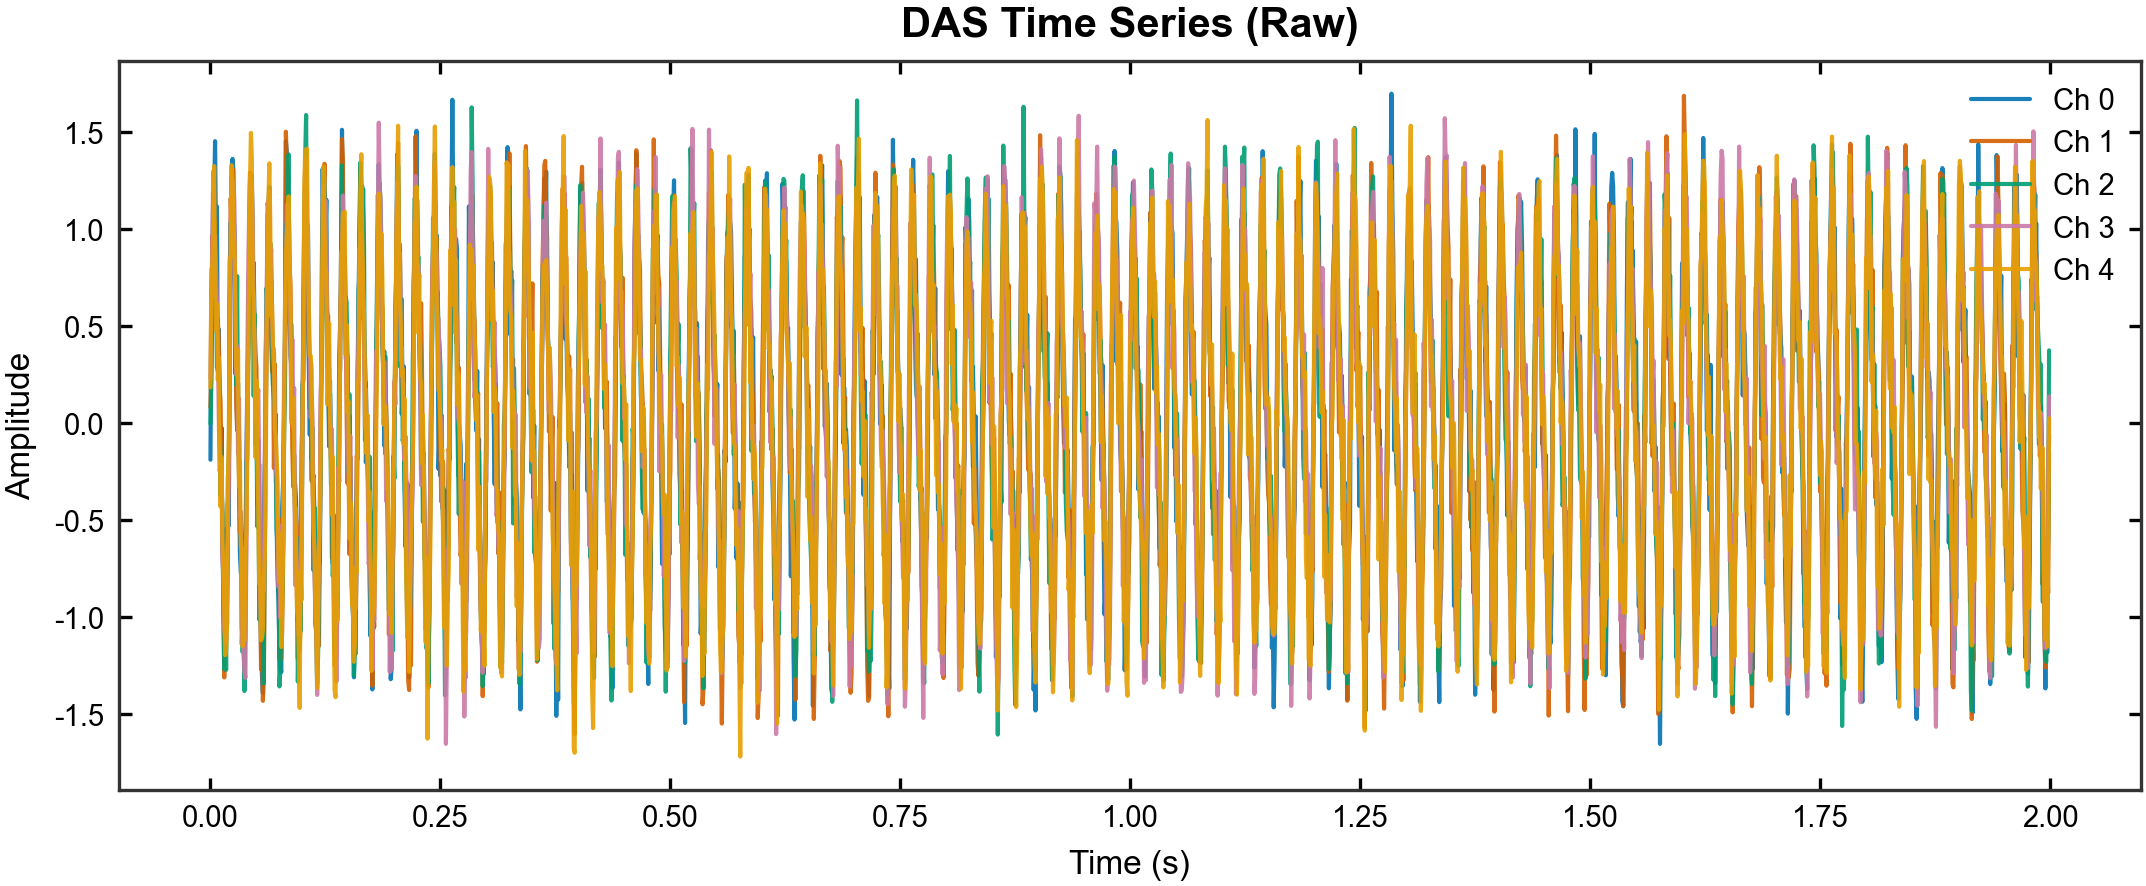

In [4]:
# 时间序列图
fig = frame.plot_ts(title="DAS Time Series (Raw)")
plt.show()

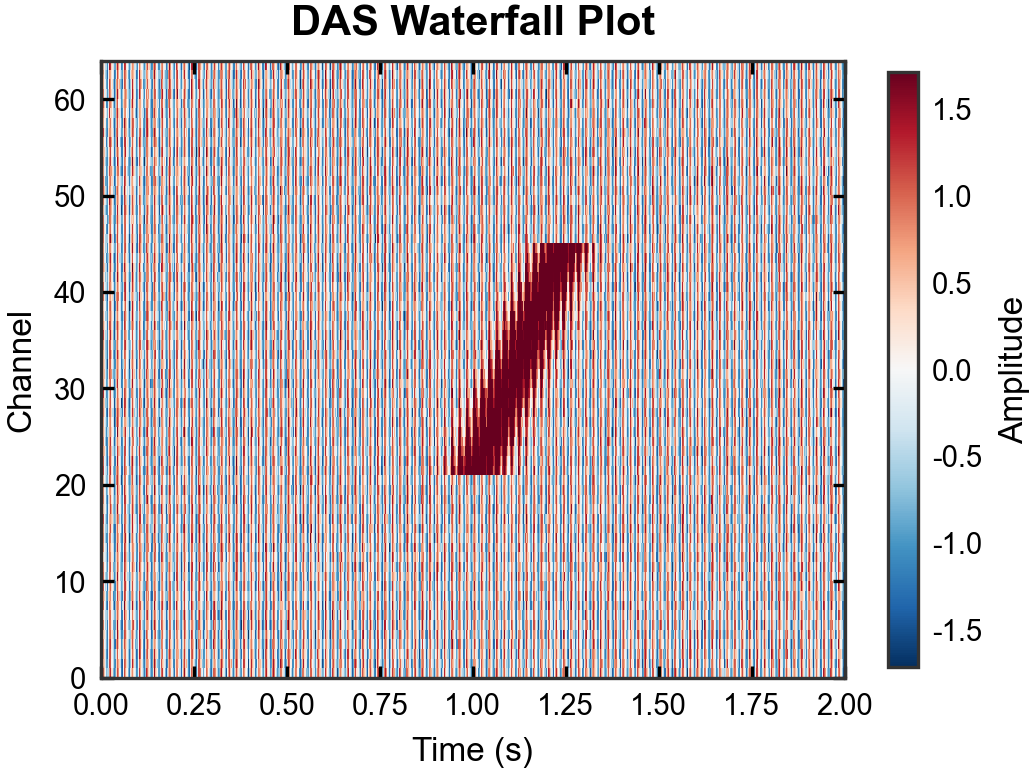

In [5]:
# 热图（瀑布图）
fig = frame.plot_heatmap(title="DAS Waterfall Plot")
plt.show()

## 5. 链式信号处理

DASMatrix 支持类似 data.table 的链式操作语法，所有操作都是**惰性**的，只有调用 `.collect()` 或可视化方法时才会执行。

In [6]:
# 链式处理示例
processed = (
    frame
    .detrend()                    # 去趋势
    .bandpass(low=20, high=150)   # 带通滤波 (20-150 Hz)
    .normalize()                  # 归一化
)

# 此时还没有执行任何计算！
print("链式操作已定义，等待执行...")

# 调用 collect() 触发计算
result = processed.collect()
print(f"处理完成！结果形状: {result.shape}")

链式操作已定义，等待执行...
处理完成！结果形状: (2000, 64)


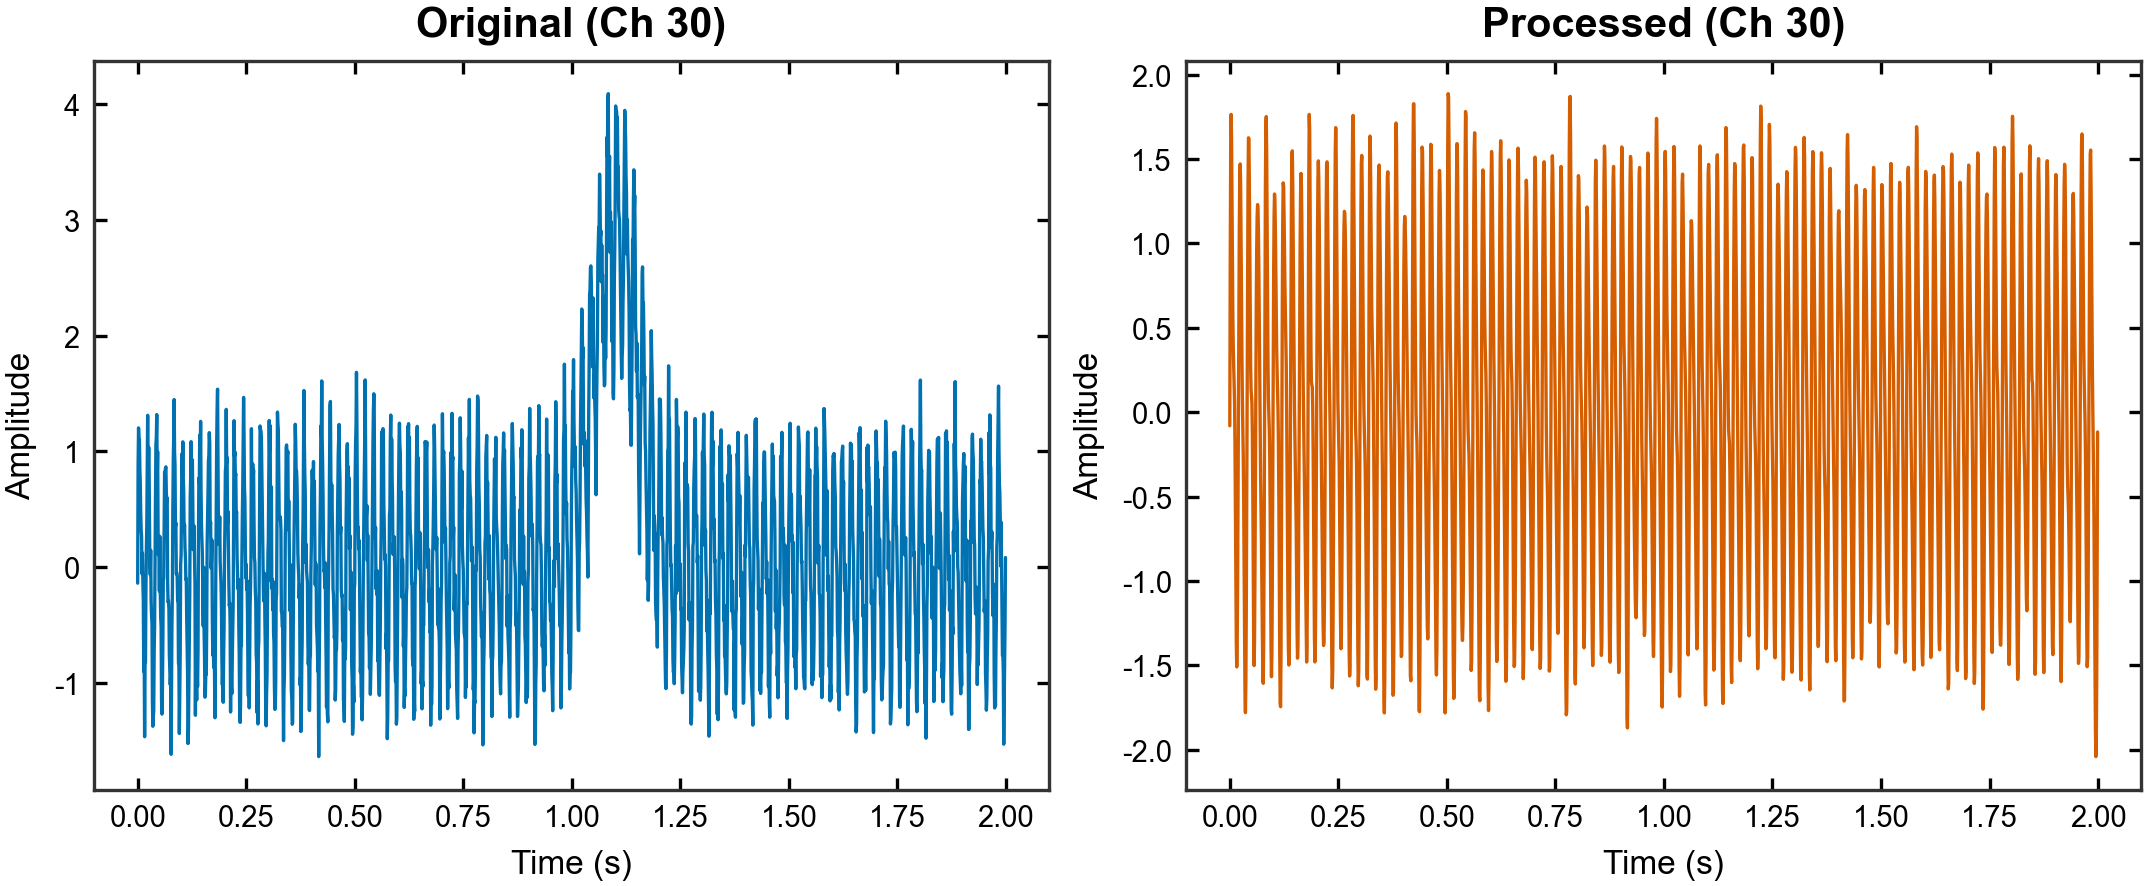

In [7]:
# 对比原始数据和处理后数据
fig, axes = plt.subplots(1, 2, figsize=(7.2, 3), constrained_layout=True)

# 原始数据
ax = axes[0]
ax.plot(np.arange(raw_data.shape[0]) / 1000, raw_data[:, 30], 
        color='#0072B2', linewidth=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Original (Ch 30)', fontweight='bold')

# 处理后数据
ax = axes[1]
ax.plot(np.arange(result.shape[0]) / 1000, result[:, 30],
        color='#D55E00', linewidth=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Processed (Ch 30)', fontweight='bold')

plt.show()

## 6. 滤波器详解

DASMatrix 提供多种滤波器：
- `lowpass(cutoff)` - 低通滤波
- `highpass(cutoff)` - 高通滤波  
- `bandpass(low, high)` - 带通滤波
- `notch(freq)` - 陷波滤波
- `median_filter(k)` - 中值滤波

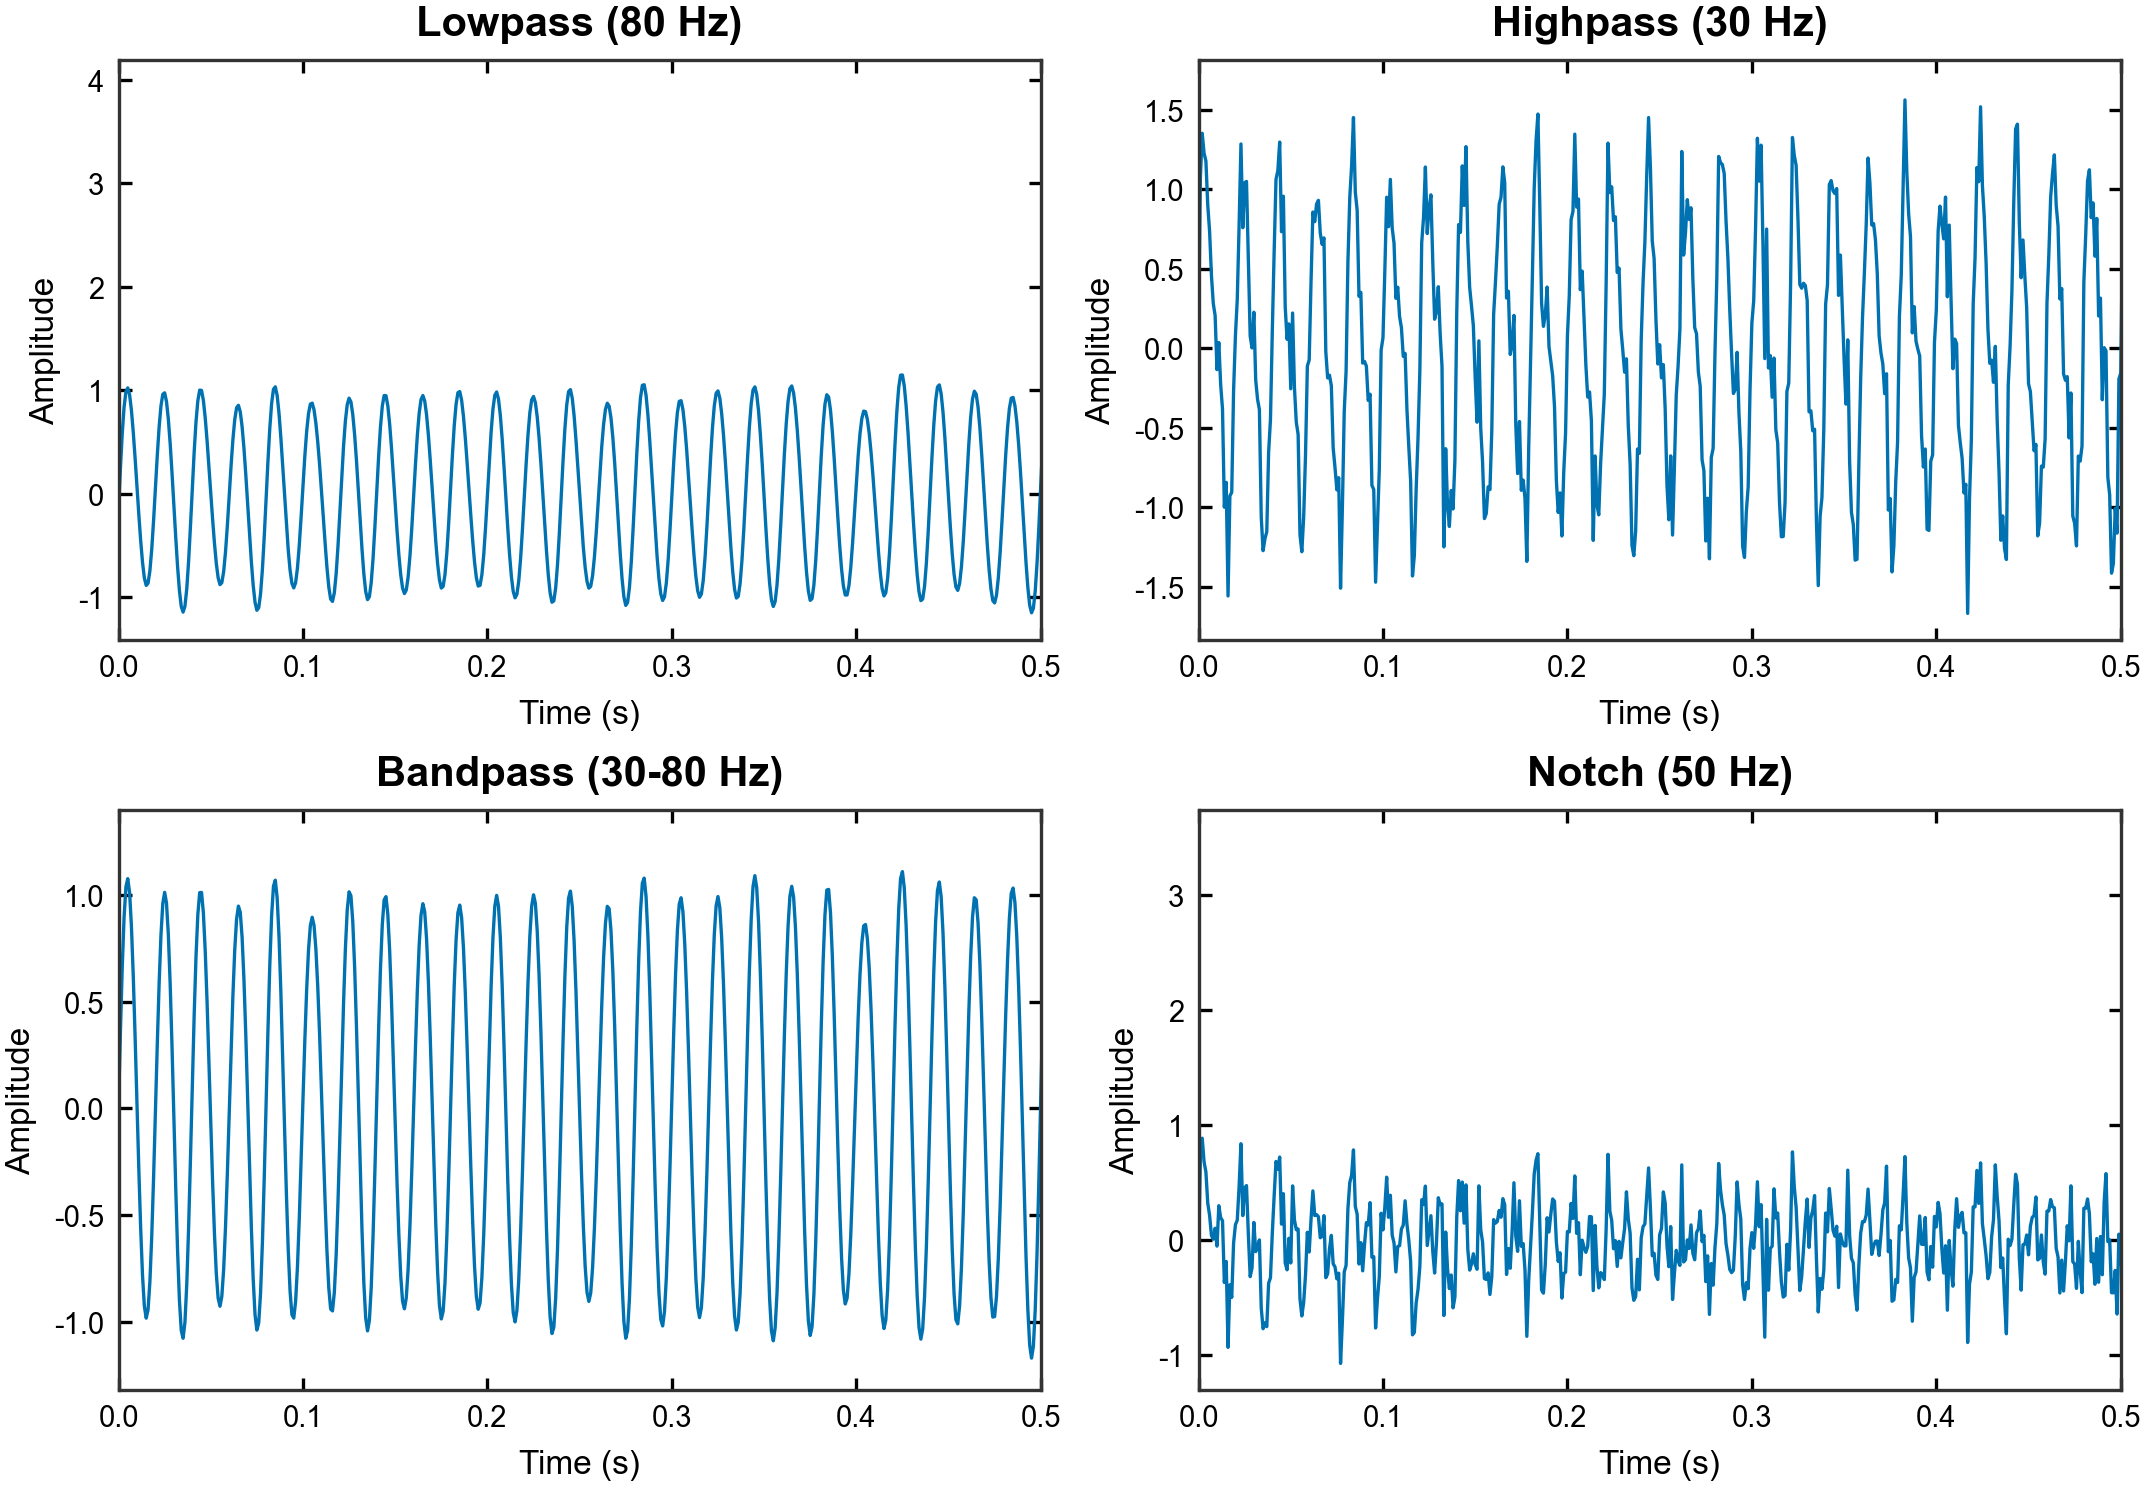

In [8]:
# 不同滤波器效果对比
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5), constrained_layout=True)

filters = [
    ('lowpass', frame.lowpass(cutoff=80), 'Lowpass (80 Hz)'),
    ('highpass', frame.highpass(cutoff=30), 'Highpass (30 Hz)'),
    ('bandpass', frame.bandpass(low=30, high=80), 'Bandpass (30-80 Hz)'),
    ('notch', frame.notch(freq=50), 'Notch (50 Hz)'),
]

ch = 30  # 选择通道
t = np.arange(raw_data.shape[0]) / 1000

for ax, (name, filtered, title) in zip(axes.flat, filters):
    data = filtered.collect()[:, ch]
    ax.plot(t, data, color='#0072B2', linewidth=0.8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title, fontweight='bold', fontsize=10)
    ax.set_xlim(0, 0.5)  # 只显示前0.5秒

plt.show()

## 7. 频域分析

DASMatrix 提供多种频域变换：
- `fft()` - 快速傅里叶变换
- `stft(nperseg)` - 短时傅里叶变换
- `wavelet()` / `cwt()` - 小波变换
- `hilbert()` - 希尔伯特变换
- `envelope()` - 包络提取

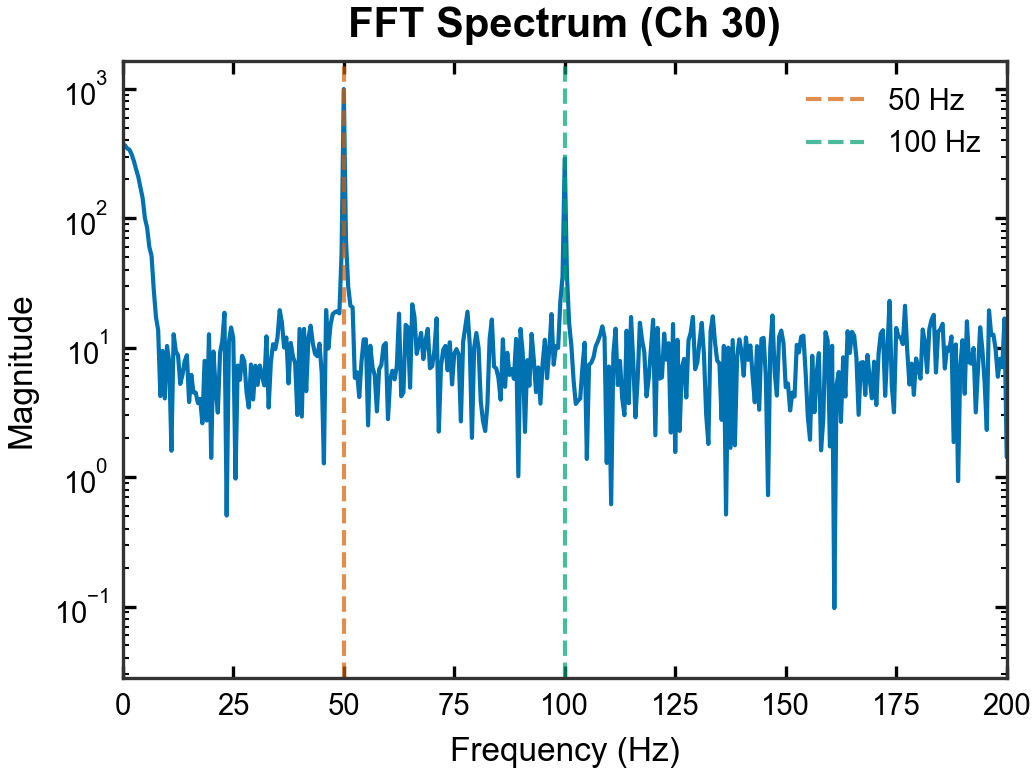

In [9]:
# FFT 分析
fft_result = frame.fft().collect()

# 计算频率轴
n_samples = raw_data.shape[0]
freqs = np.fft.fftfreq(n_samples, 1/1000)[:n_samples//2]
fft_magnitude = fft_result[:n_samples//2, 30]  # 取单边频谱

fig, ax = plt.subplots(figsize=FigureSize.SINGLE_COLUMN.value)
ax.semilogy(freqs, fft_magnitude, color='#0072B2', linewidth=1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('FFT Spectrum (Ch 30)', fontweight='bold')
ax.set_xlim(0, 200)
ax.axvline(50, color='#D55E00', linestyle='--', alpha=0.7, label='50 Hz')
ax.axvline(100, color='#009E73', linestyle='--', alpha=0.7, label='100 Hz')
ax.legend(frameon=False)
plt.show()

STFT 结果形状: (65, 33, 64) (频率 × 时间 × 通道)


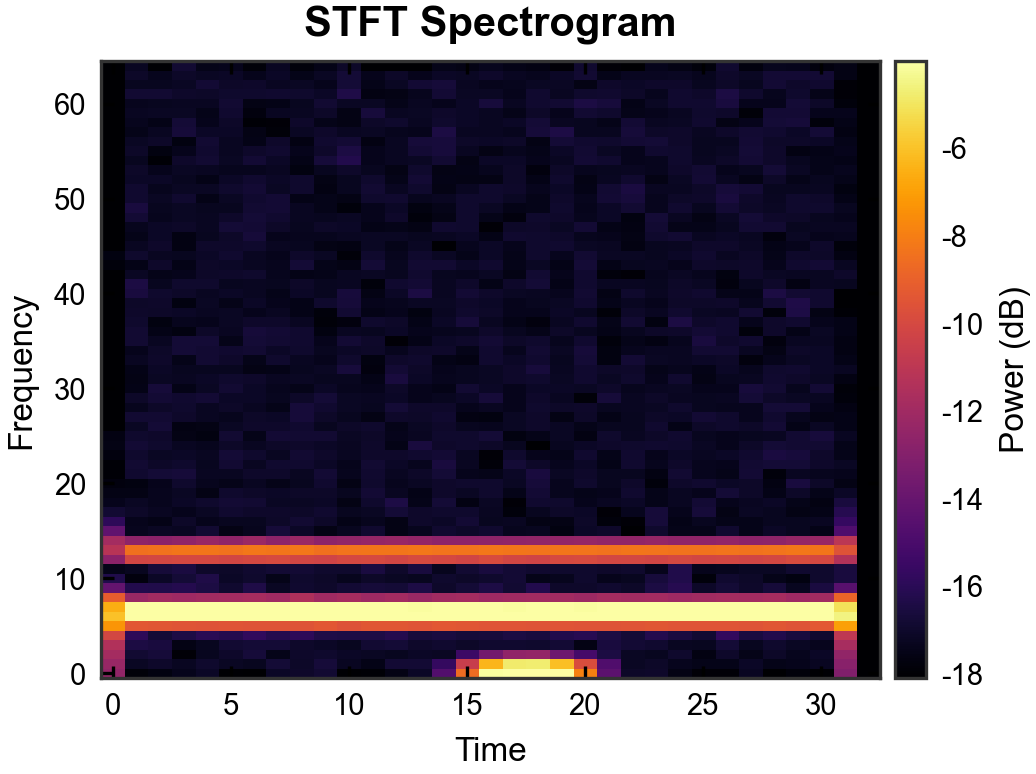

In [10]:
# STFT 时频分析
stft_result = frame.stft(nperseg=128).collect()
print(f"STFT 结果形状: {stft_result.shape} (频率 × 时间 × 通道)")

# 使用内置可视化
fig = frame.stft(nperseg=128).plot_spec(title="STFT Spectrogram")
plt.show()

/Users/qianlong/Code/DASMatrix/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/qianlong/Code/DASMatrix/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/qianlong/Code/DASMatrix/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/qianlong/Code/DASMatrix/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/qianlong/Code/DASMatrix/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170

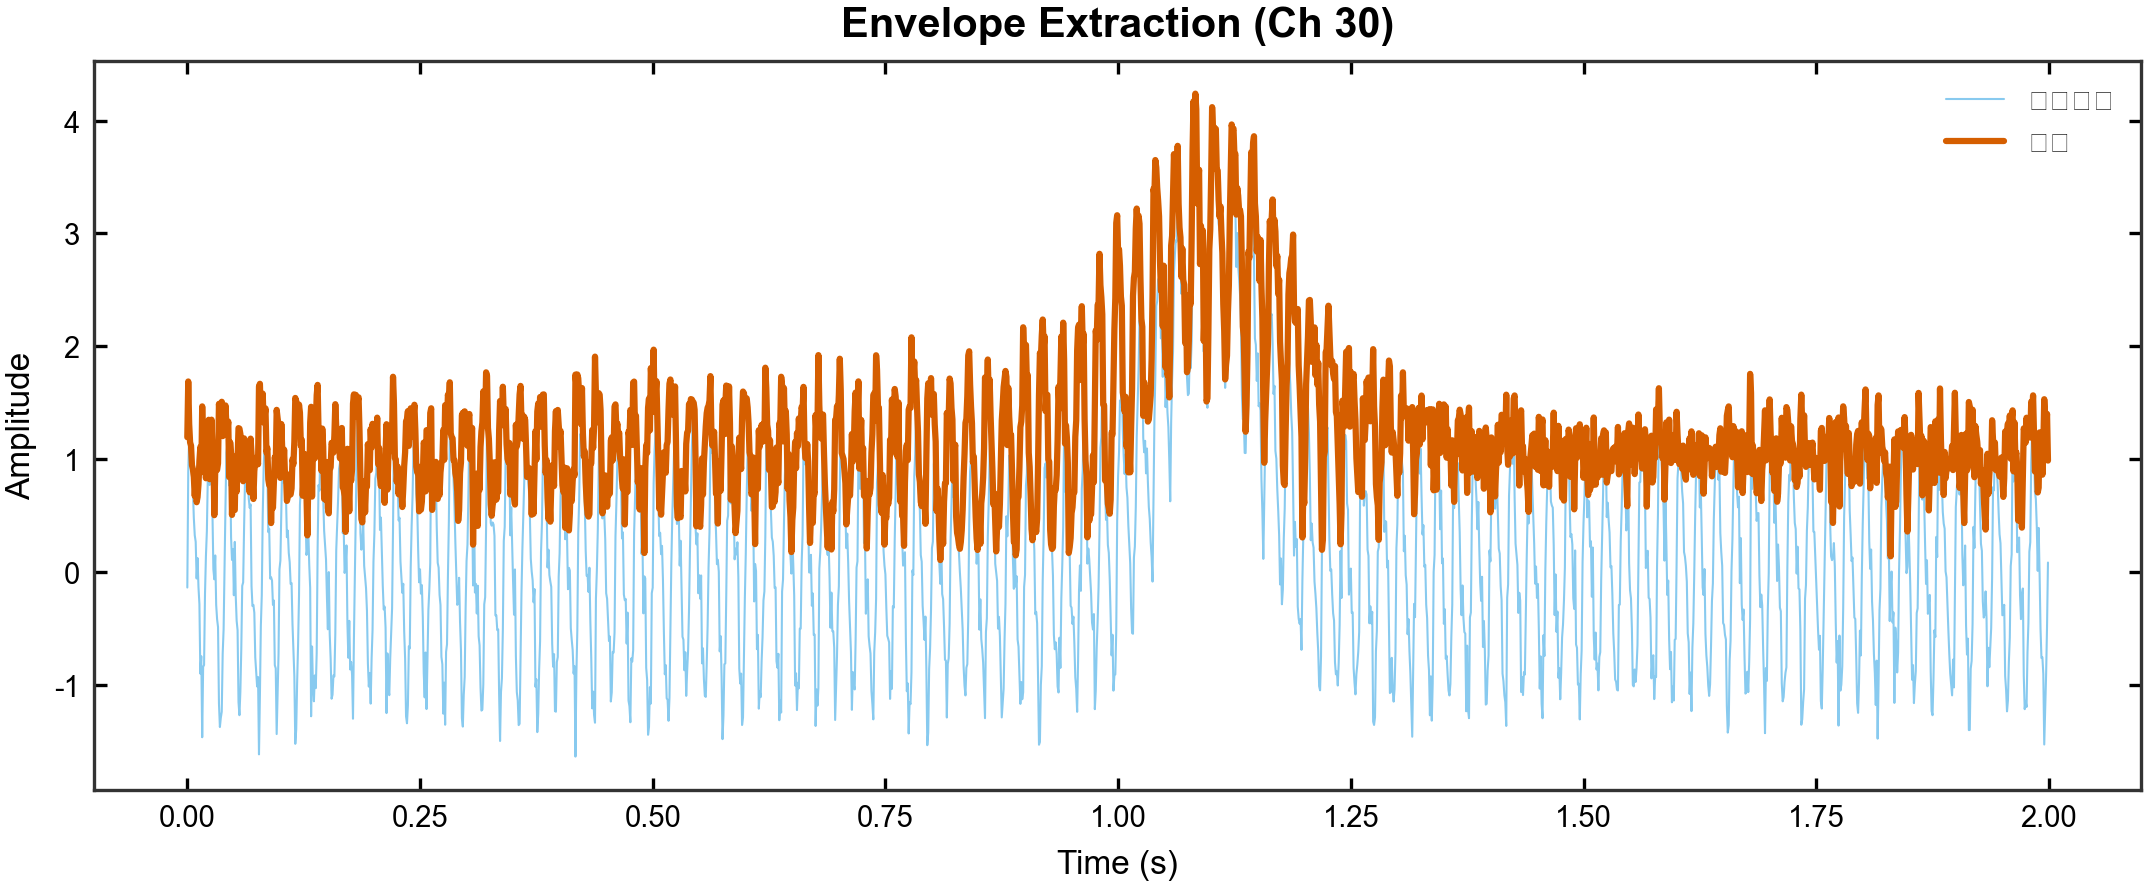

In [11]:
# 包络提取
envelope = frame.envelope().collect()

fig, ax = plt.subplots(figsize=FigureSize.WIDE.value)
t = np.arange(envelope.shape[0]) / 1000

ax.plot(t, raw_data[:, 30], color='#56B4E9', linewidth=0.5, alpha=0.7, label='原始信号')
ax.plot(t, envelope[:, 30], color='#D55E00', linewidth=1.5, label='包络')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Envelope Extraction (Ch 30)', fontweight='bold')
ax.legend(frameon=False)
plt.show()

## 8. 统计与聚合

DASMatrix 提供常用统计方法：
- `mean()`, `std()`, `max()`, `min()`
- `rms(window)` - 滑动窗口 RMS

In [12]:
# 基础统计
print("数据统计:")
print(f"  均值: {frame.mean().collect():.4f}")
print(f"  标准差: {frame.std().collect():.4f}")
print(f"  最大值: {frame.max().collect():.4f}")
print(f"  最小值: {frame.min().collect():.4f}")

数据统计:
  均值: 0.0707
  标准差: 0.8536
  最大值: 4.4962
  最小值: -1.8922


RMS 结果形状: (1951, 64)


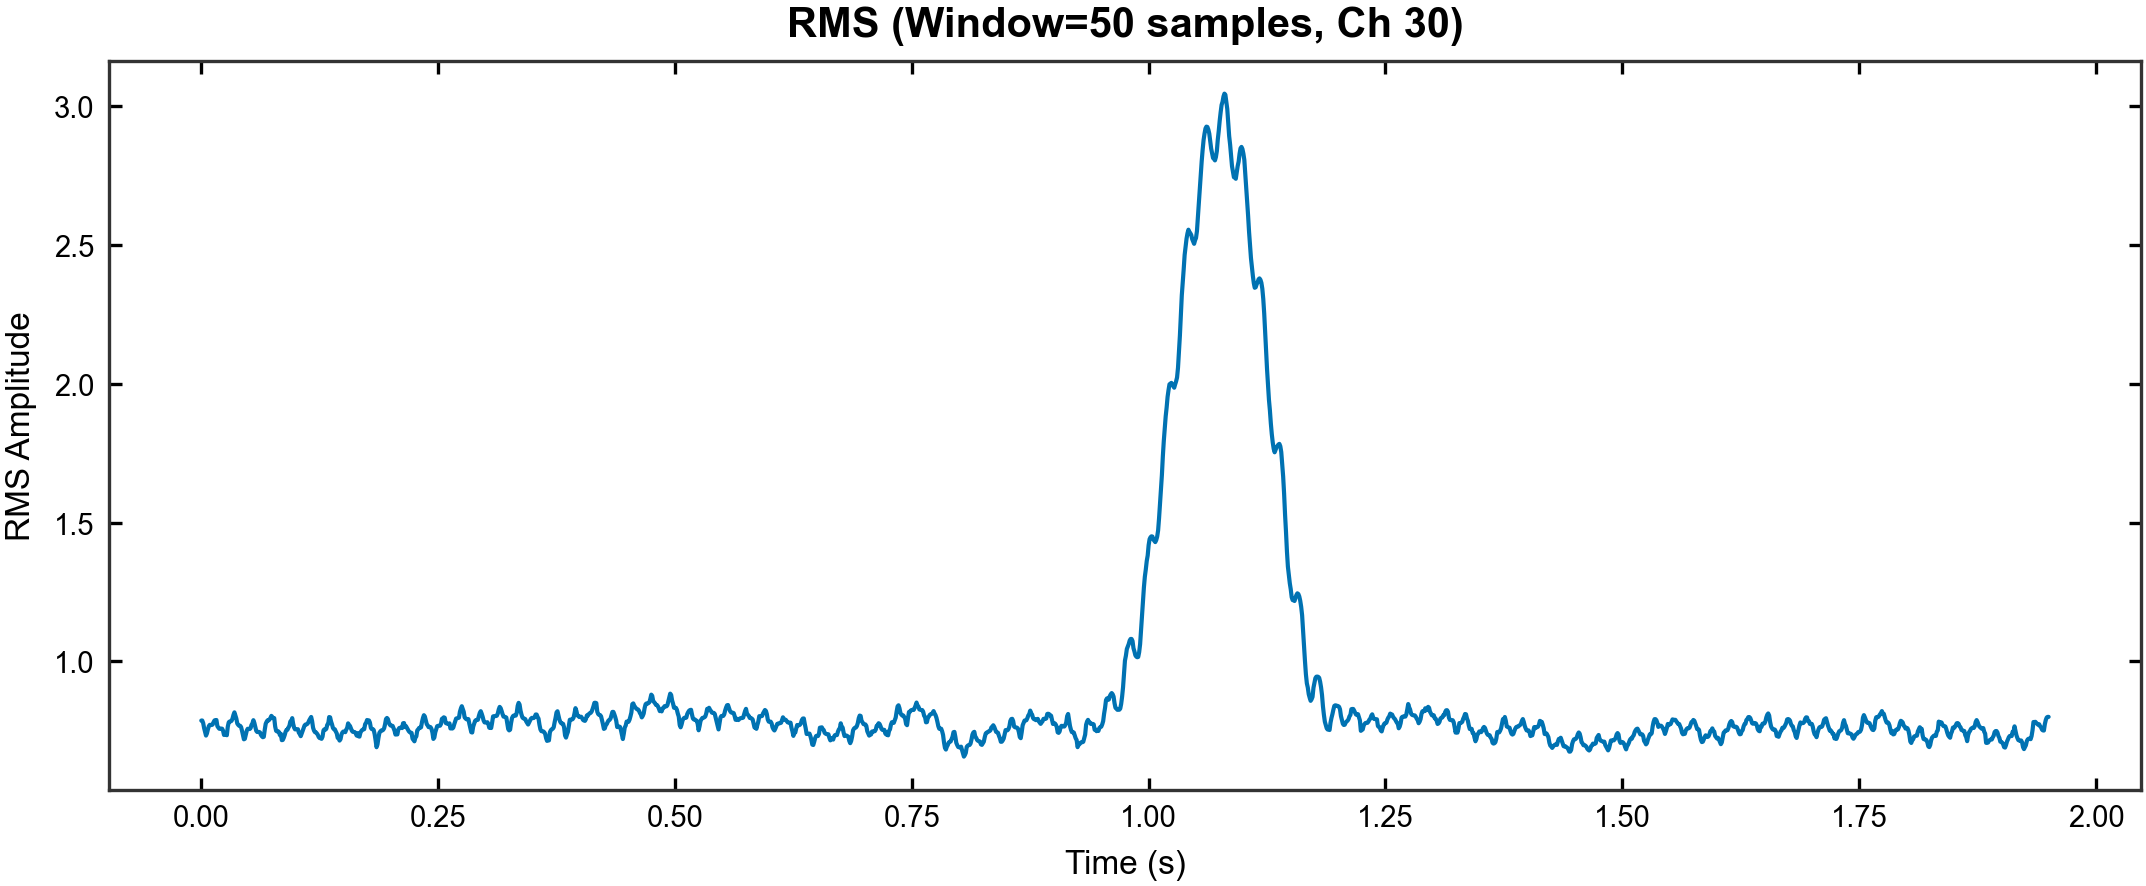

In [13]:
# RMS 滑动窗口
rms_result = frame.rms(window=50).collect()
print(f"RMS 结果形状: {rms_result.shape}")

fig, ax = plt.subplots(figsize=FigureSize.WIDE.value)
t_rms = np.arange(rms_result.shape[0]) / 1000
ax.plot(t_rms, rms_result[:, 30], color='#0072B2', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('RMS Amplitude')
ax.set_title('RMS (Window=50 samples, Ch 30)', fontweight='bold')
plt.show()

## 9. 事件检测

使用阈值检测识别异常事件。

In [14]:
# 阈值检测
# 默认阈值: 均值 + 3×标准差
detections = frame.threshold_detect().collect()

print(f"检测结果形状: {detections.shape}")
print(f"检测到的异常点数: {np.sum(detections)}")

检测结果形状: (2000, 64)
检测到的异常点数: 1797


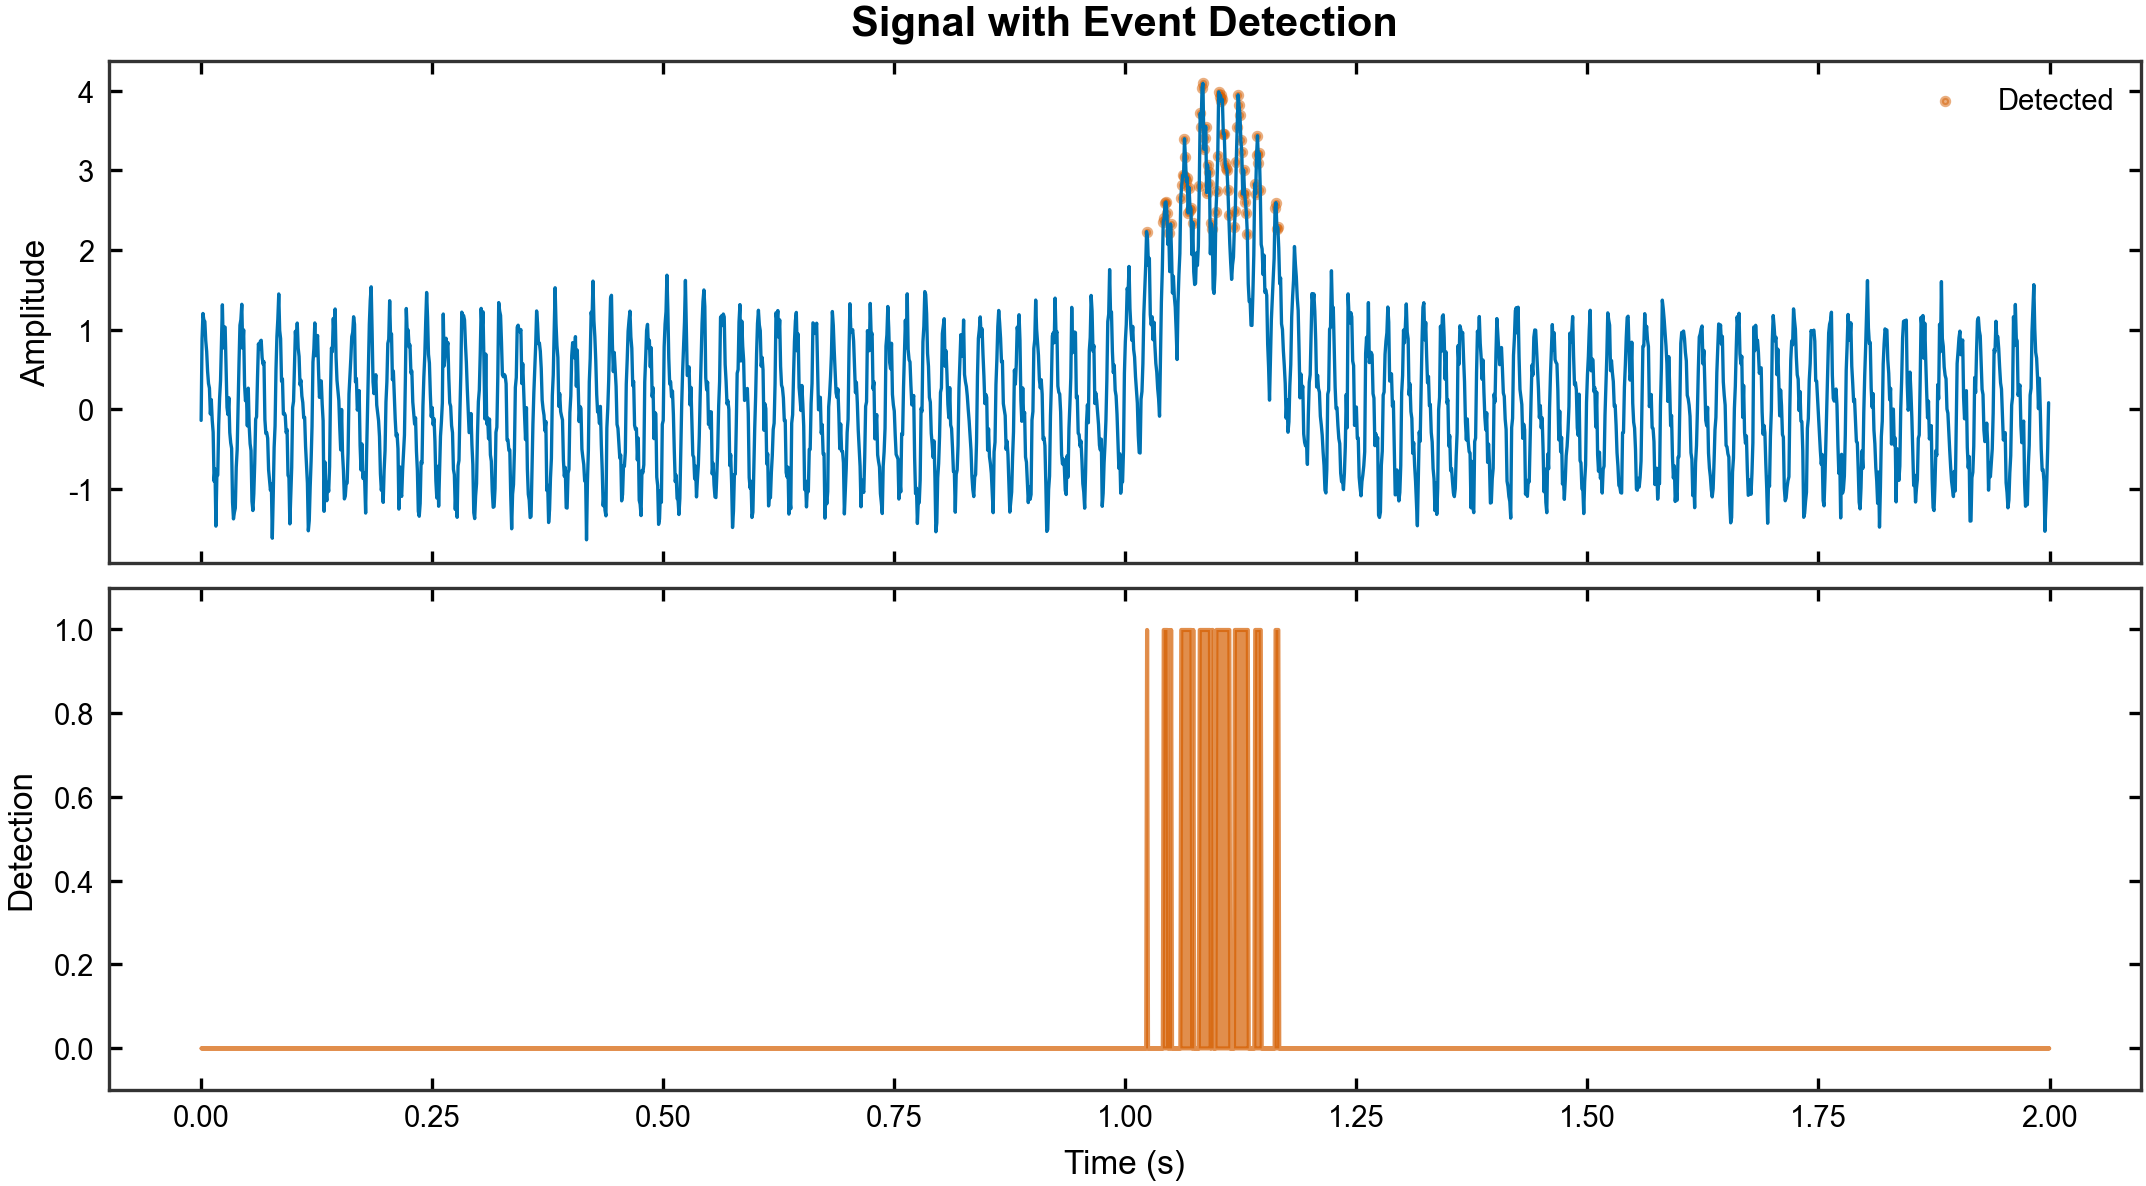

In [15]:
# 可视化检测结果
fig, axes = plt.subplots(2, 1, figsize=(7.2, 4), constrained_layout=True, sharex=True)

ch = 30
t = np.arange(raw_data.shape[0]) / 1000

# 原始信号
ax = axes[0]
ax.plot(t, raw_data[:, ch], color='#0072B2', linewidth=0.8)
ax.set_ylabel('Amplitude')
ax.set_title('Signal with Event Detection', fontweight='bold')

# 标记检测到的区域
detection_indices = np.where(detections[:, ch])[0]
if len(detection_indices) > 0:
    ax.scatter(t[detection_indices], raw_data[detection_indices, ch],
               color='#D55E00', s=3, alpha=0.5, label='Detected')
    ax.legend(frameon=False)

# 检测掩码
ax = axes[1]
ax.fill_between(t, detections[:, ch].astype(float), alpha=0.7, color='#D55E00')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Detection')
ax.set_ylim(-0.1, 1.1)

plt.show()

## 10. 完整处理流程示例

展示一个完整的 DAS 数据处理流程。

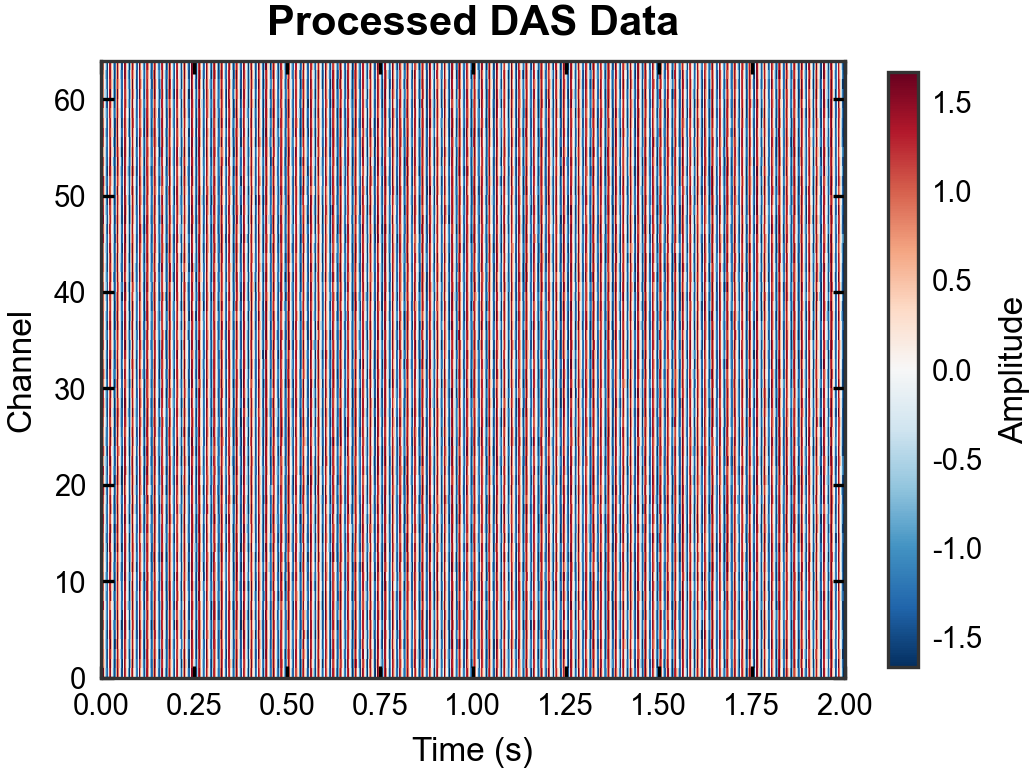

In [16]:
# 完整处理流程
result = (
    df.from_array(raw_data, fs=1000)  # 创建 DASFrame
    .detrend()                         # 去趋势
    .bandpass(low=20, high=150)        # 带通滤波
    .normalize()                       # 归一化
)

# 可视化结果
fig = result.plot_heatmap(title="Processed DAS Data")
plt.show()

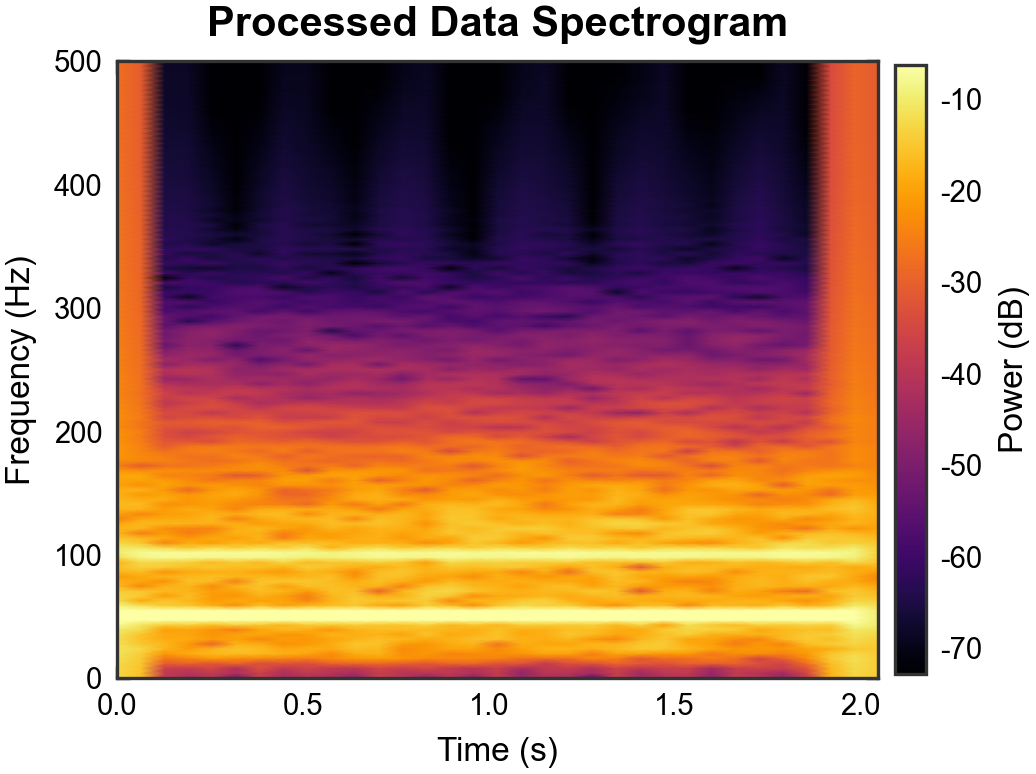

In [17]:
# 频谱分析
fig = result.plot_spec(title="Processed Data Spectrogram")
plt.show()

## 11. 高级可视化：多面板组合图

创建符合 Nature/Science 投稿要求的多面板图。

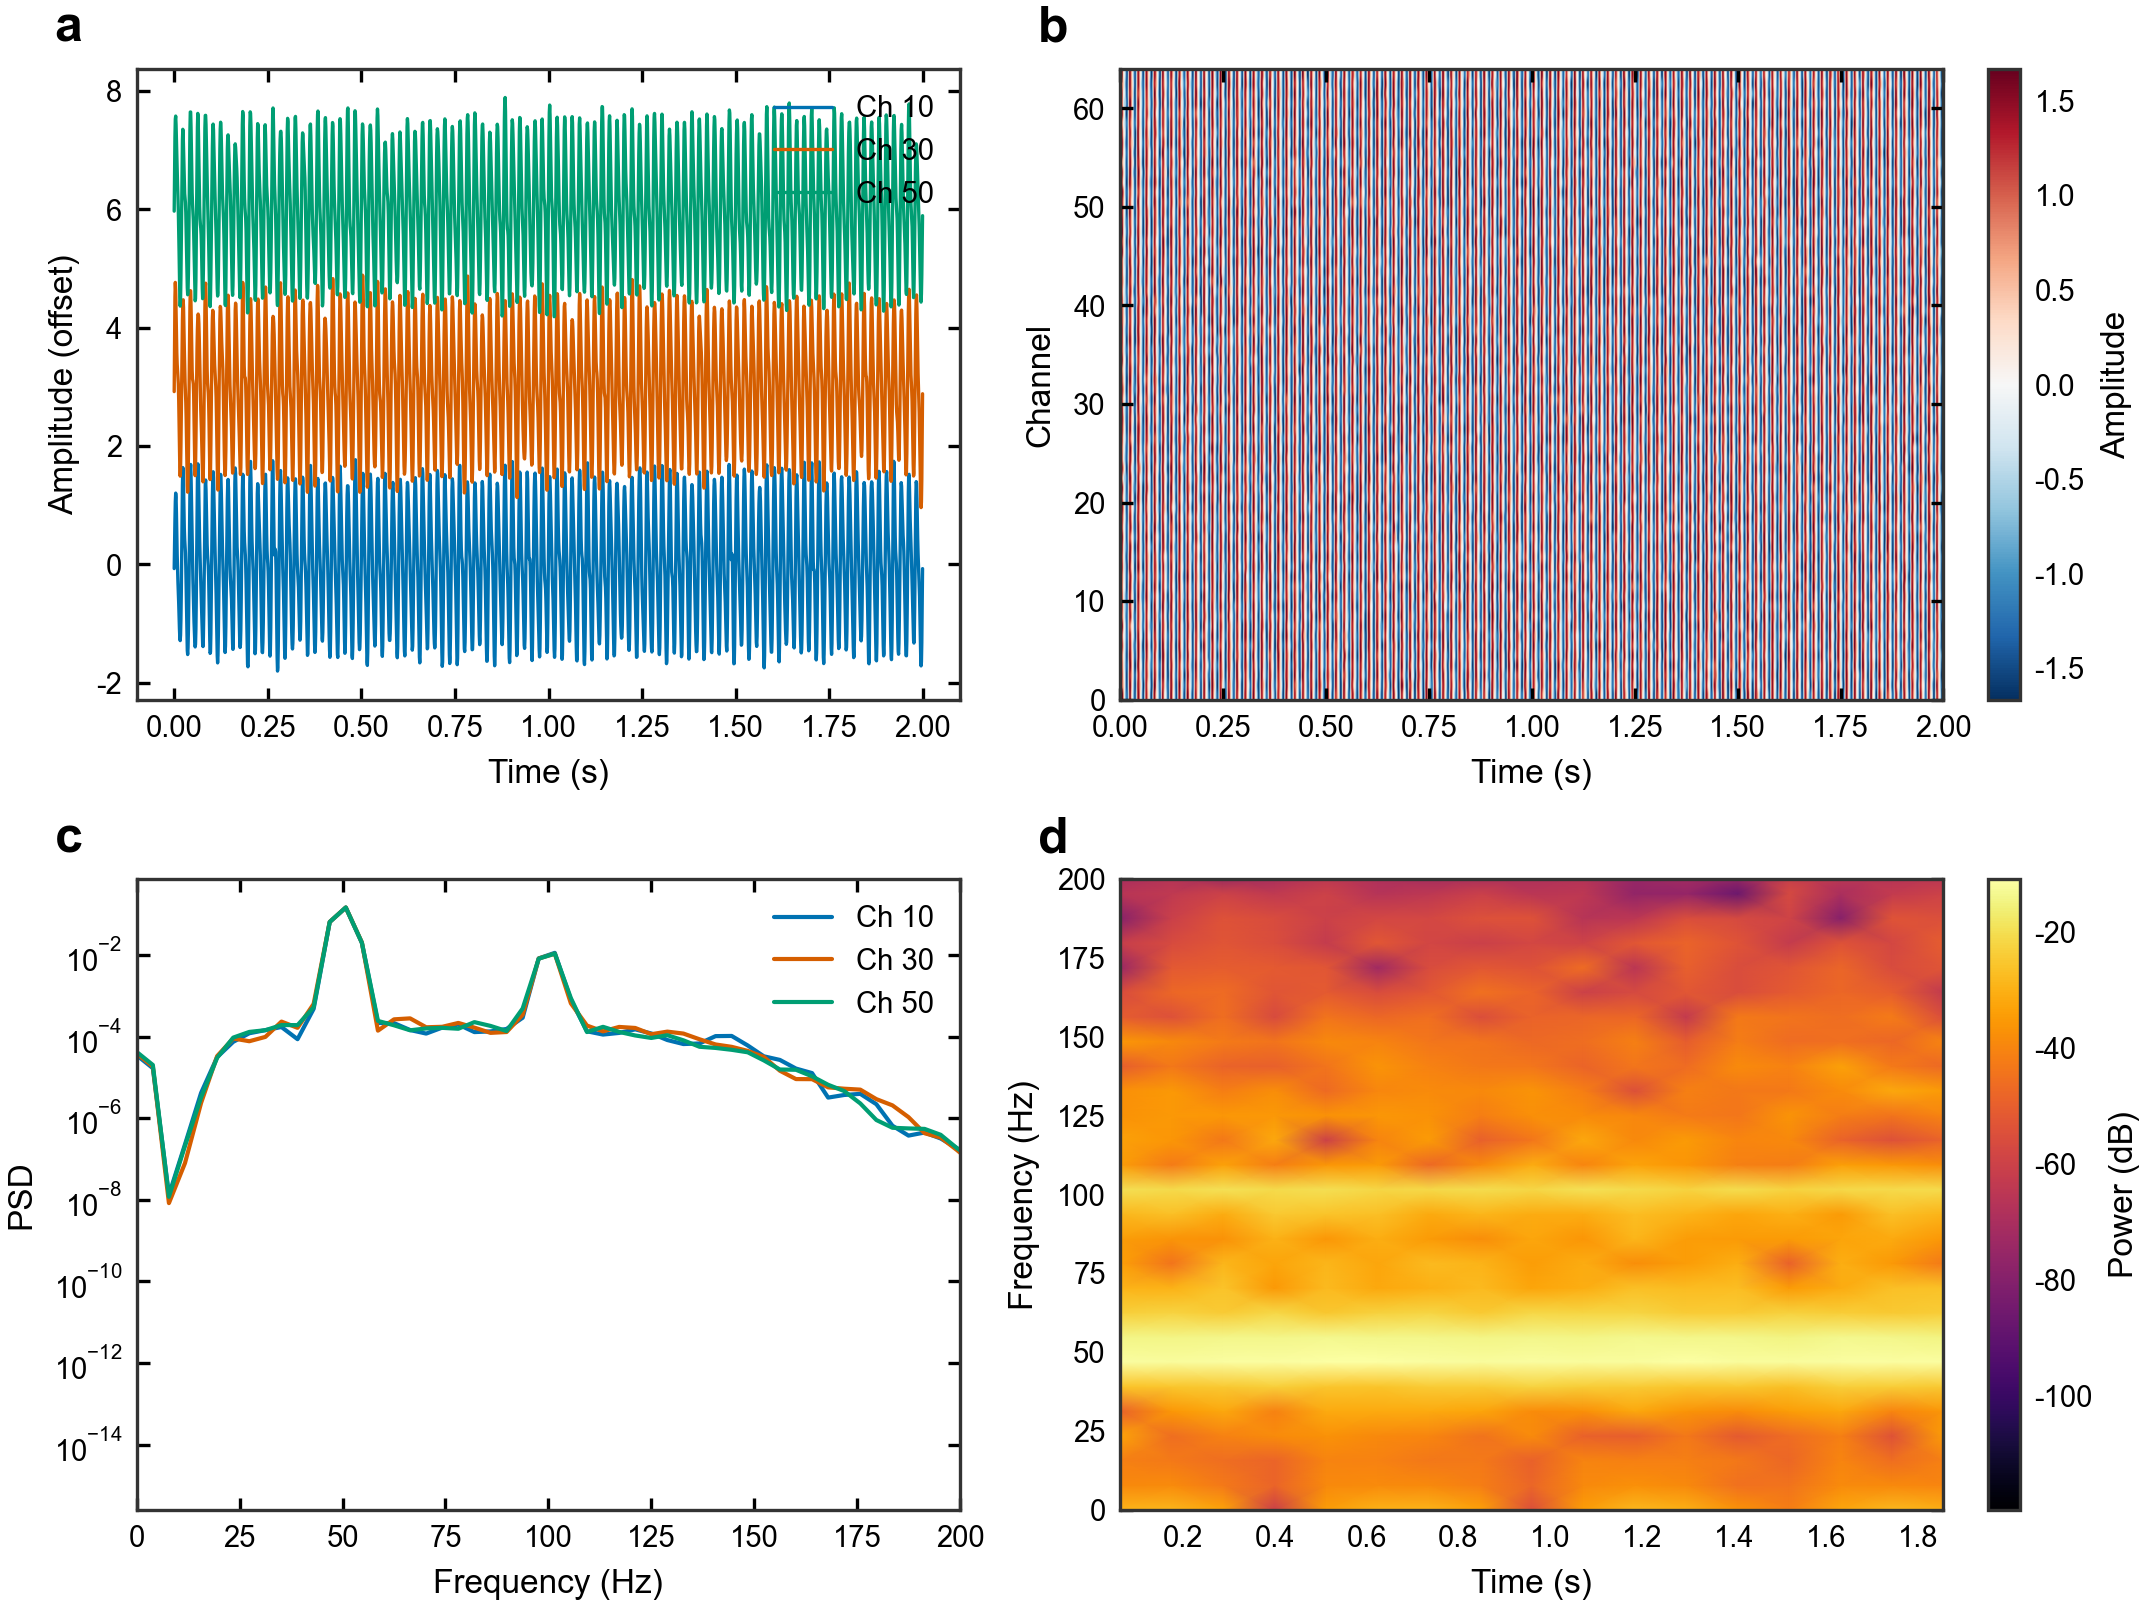

In [18]:
from DASMatrix.visualization import add_panel_label, add_colorbar, setup_axis
from scipy import signal

# 获取配置
config = VisualizationConfig()

# 创建多面板图
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.4), constrained_layout=True)

# 处理数据
processed_data = result.collect()
t = np.arange(processed_data.shape[0]) / 1000

# a) 多通道时间序列
ax = axes[0, 0]
for i, ch in enumerate([10, 30, 50]):
    ax.plot(t, processed_data[:, ch] + i*3, 
            color=config.colors.primary[i], linewidth=0.8,
            label=f'Ch {ch}')
setup_axis(ax, xlabel='Time (s)', ylabel='Amplitude (offset)', config=config)
ax.legend(frameon=False, fontsize=7, loc='upper right')
add_panel_label(ax, 'a')

# b) 热图
ax = axes[0, 1]
vmax = np.percentile(np.abs(processed_data), 98)
im = ax.imshow(processed_data.T, aspect='auto', origin='lower',
               cmap=config.colors.diverging,
               extent=[0, 2, 0, 64],
               vmin=-vmax, vmax=vmax)
add_colorbar(fig, im, ax, label='Amplitude', config=config)
setup_axis(ax, xlabel='Time (s)', ylabel='Channel', config=config)
add_panel_label(ax, 'b')

# c) 功率谱密度
ax = axes[1, 0]
for i, ch in enumerate([10, 30, 50]):
    f, Pxx = signal.welch(processed_data[:, ch], fs=1000, nperseg=256)
    ax.semilogy(f, Pxx, color=config.colors.primary[i], 
                linewidth=1, label=f'Ch {ch}')
setup_axis(ax, xlabel='Frequency (Hz)', ylabel='PSD', config=config)
ax.set_xlim(0, 200)
ax.legend(frameon=False, fontsize=7)
add_panel_label(ax, 'c')

# d) 时频图
ax = axes[1, 1]
f, t_spec, Sxx = signal.spectrogram(processed_data[:, 30], fs=1000, nperseg=128)
im = ax.pcolormesh(t_spec, f, 10*np.log10(Sxx + 1e-12),
                   shading='gouraud', cmap=config.colors.spectrogram,
                   rasterized=True)
add_colorbar(fig, im, ax, label='Power (dB)', config=config)
setup_axis(ax, xlabel='Time (s)', ylabel='Frequency (Hz)', config=config)
ax.set_ylim(0, 200)
add_panel_label(ax, 'd')

plt.show()

## 12. 保存结果

DASMatrix 支持多种输出格式。

In [ ]:
# 保存处理后的数据到 HDF5
# result.to_h5('output/processed_data.h5')

# 保存到 Parquet（需要 pyarrow）
# result.to_parquet('output/processed_data.parquet')

# 保存图表
from DASMatrix.visualization import save_figure

fig = result.plot_heatmap(title="Final Result")
# save_figure(fig, 'output/final_result', formats=('pdf', 'png'))
plt.show()

print("保存示例完成！（注释掉了实际保存操作）")

## 13. 小结

### 核心概念

1. **DASFrame** - 核心数据容器，支持链式操作
2. **惰性计算** - 操作定义后延迟执行，调用 `.collect()` 触发
3. **Nature 风格可视化** - 自动应用期刊级别样式

### 常用操作速查

```python
# 创建
frame = df.from_array(data, fs=1000)
frame = df.read('data.h5')

# 预处理
frame.detrend().demean().normalize()

# 滤波
frame.bandpass(low=10, high=100)
frame.lowpass(cutoff=50)

# 变换
frame.fft()
frame.stft(nperseg=256)
frame.envelope()

# 统计
frame.mean()
frame.rms(window=100)

# 检测
frame.threshold_detect()

# 可视化
frame.plot_ts()
frame.plot_heatmap()
frame.plot_spec()

# 输出
frame.collect()  # 返回 numpy 数组
frame.to_h5('output.h5')
```

---

**更多信息请参考 [DASMatrix GitHub 仓库](https://github.com/yourusername/DASMatrix)**